# Investigate MI pulse train peak powers

## Import libraries and define fiber

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ssfm_functions import *
from scipy.signal import find_peaks
import pandas as pd
from time import time, sleep
N  = 2**14 #Number of points
dt = 0.1e-12 #Time resolution [s] 

timeFreq_test=timeFreq_class(N,dt)


#Define fiber parameters
Length          = 500      #Fiber length in m

gamma           = 40e-3     #Nonlinearity parameter in 1/W/m 
beta2           = -100e3    #Dispersion in fs^2/m (units typically used when referring to beta2) 
beta2          *= (1e-30)  #Convert fs^2 to s^2 so everything is in SI units
alpha_dB_per_m  = 0.0e-3   #Power attenuation coeff in decibel per m. Usual value at 1550nm is 0.2 dB/km

#Note:  beta2>0 is normal dispersion with red light pulling ahead, 
#       causing a negative leading chirp
#       
#       beta2<0 is anormalous dispersion with blue light pulling ahead, 
#       causing a positive leading chirp.



#  Initialize class
fiber=Fiber_class(Length, gamma, beta2, alpha_dB_per_m)

#Define step config
MI_stepConfig=("fixed",2**11,1)

 ### timeFreq Configuration Parameters ###
  Number of points = 16384
  Start time, tmin = -819.200ps
  Stop time, tmax = 819.200ps
  Time resolution, dt = 0.100ps
  
  Start frequency= -5.000THz
  Stop frequency = 4.999THz
  Frequency resolution= 610.314MHz
   


## Define noisy pulse, propagate through fiber and record peak powers

 
Run number 0 out of 1. 0.0% done
########### Initializing SSFM!!! ###########
 ### timeFreq Configuration Parameters ###
  Number of points = 16384
  Start time, tmin = -819.200ps
  Stop time, tmax = 819.200ps
  Time resolution, dt = 0.100ps
  
  Start frequency= -5.000THz
  Stop frequency = 4.999THz
  Frequency resolution= 610.314MHz
   
 
Calculating zinfo
Stepmode = (fixed,2048), stepSafetyFactor = 1
 ### Characteristic parameters of simulation: ###
  Length_fiber = 0.5km. Power loss coeff (alpha) = 0.0000 dB/km = 0.0000Np/km 
  L_eff = 0.5000 km
  Length_disp=400.0000km
  Length_NL=0.0249km
  N_soliton=126.7652
  (N_soliton)^2=16069.4252
 
  sign(beta2) = -1.0, so Solitons and Modulation Instability may occur 
   z_soliton = 628.3185
   N_soliton=126.7652
   (N_soliton)^2=16069.4252
 
   Freq. with max MI gain = 142.6610GHz
   Max MI gain = 80.3471/km 
   Min MI distance = 1/gain_MI = Length_NL/2 = 0.0124km 
 


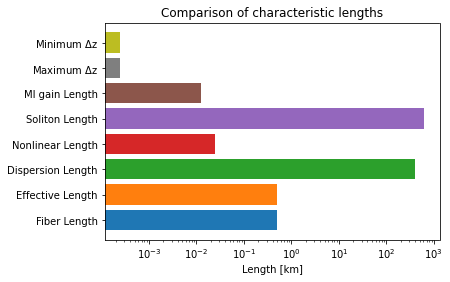

Running SSFM with nsteps = 2048
Finished running SSFM!!!
This run took 8.999878644943237s = 0.14999797741572063min = 0.0024999662902620103h 
Time so far = 1671220280.3349507s = 27853671.338915844min = 464227.8556485974h 
 
Running SSFM 1 times took 9.000948429107666s = 0.15001580715179444min = 0.002500263452529907h
That is an average of 9.000948429107666s = 0.15001580715179444min = 0.002500263452529907h per run
 
Finished simulating everyting. Saving results


In [2]:
testAmplitude              = 1                            #Amplitude in units of sqrt(W)
testDuration               = 2000*timeFreq_test.time_step #Pulse 1/e^2 duration [s]
testOffset                 = 0                            #Time offset
testChirp                  = 0                            #Chirp factor
testCarrierFreq            = 0                            #Freq. offset
testPulseType              = 'gaussian'                   #'Gaussian', 'square', 'sech'
testOrder                  = 1                            #Order of Gaussian pulse
testNoiseAmplitude         = testAmplitude* 1e-3          #Added ASE noise amplitude

number_of_runs = 1

#Add new peak powers to previous list of peak powers
resultArray=np.array(  pd.read_csv("peakValues_MI.csv")  )

#Monitor runtime
t_start=time()
t_so_far=t_start
t_this_run=0.0

#Begin loop over runs
for i in range(number_of_runs):
    print(' ')
    print(f"Run number {i} out of {number_of_runs}. {np.floor(i/number_of_runs*100)}% done")
    
    #Generate new noisy pulse
    testInputSignal = input_signal_class(timeFreq_test, 
                                     testAmplitude ,
                                     testDuration,
                                     testOffset,
                                     testChirp,
                                     testCarrierFreq,
                                     testPulseType,
                                     testOrder,
                                     testNoiseAmplitude)
    
    #Run SSFM
    ssfm_result_test = SSFM(fiber,testInputSignal,stepConfig=MI_stepConfig)
    
    #Extract results close to peak of input pulse, where light is almost CW
    nrange_pulse=800
    cutoff_pulse=-30
    chirpPlotRange_pulse=(-100,100)
    matrix = ssfm_result_test.pulseMatrix 
    P_final=getPower(matrix[-1,int(ssfm_result_test.timeFreq.number_of_points/2-nrange_pulse):int(ssfm_result_test.timeFreq.number_of_points/2+nrange_pulse)])
    
    #Extract indices of peak powers using scipy.signal.find_peaks
    peak_indices,_ = find_peaks(P_final,height=(0.25,10000),width = 5)    
    
    #Extract peak powers and save to array
    peakPowers=P_final[peak_indices]
    resultArray=np.append(resultArray,peakPowers)
    
    #Print time info and do next SSFM run
    t_this_run = time()- t_so_far
    t_so_far += t_this_run 
    
    print(f"This run took {t_this_run}s = {t_this_run/60}min = {t_this_run/60/60}h ")
    print(f"Time so far = {t_so_far}s = {t_so_far/60}min = {t_so_far/60/60}h ")

#Finished loop
t_end=time()
t_run = t_end-t_start
print(' ')
print(f"Running SSFM {number_of_runs} times took {t_run}s = {t_run/60}min = {t_run/60/60}h")
print(f"That is an average of {t_run/number_of_runs}s = {t_run/60/number_of_runs}min = {t_run/60/60/number_of_runs}h per run")
print(' ')

#Save results to .csv file
print("Finished simulating everyting. Saving results")
df=pd.DataFrame(resultArray)
df.to_csv('peakValues_MI.csv',index=False)


## Show example of extracted peak powers

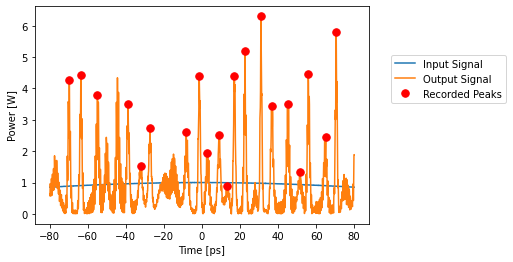

In [3]:
t=ssfm_result_test.timeFreq.t[int(ssfm_result_test.timeFreq.number_of_points/2-nrange_pulse):int(ssfm_result_test.timeFreq.number_of_points/2+nrange_pulse)]
plt.figure()
plt.plot(t*1e12,getPower(   testInputSignal.amplitude[int(ssfm_result_test.timeFreq.number_of_points/2-nrange_pulse):int(ssfm_result_test.timeFreq.number_of_points/2+nrange_pulse)]   ),'C0',label='Input Signal')
plt.plot(t*1e12,P_final,'C1',label='Output Signal')
plt.plot(t[peak_indices]*1e12,peakPowers,'r.',markersize=15,label='Recorded Peaks')
plt.ylabel('Power [W]')
plt.xlabel('Time [ps]')
plt.legend(bbox_to_anchor=(1.05,0.8))
plt.show()

## Plot data

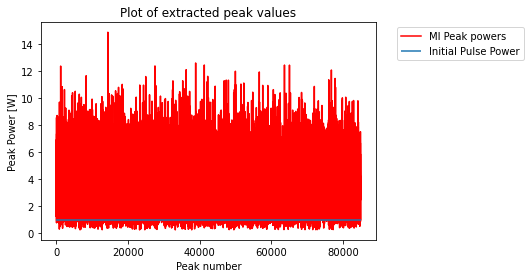

Highest peak power recorded = 14.848672564137273W


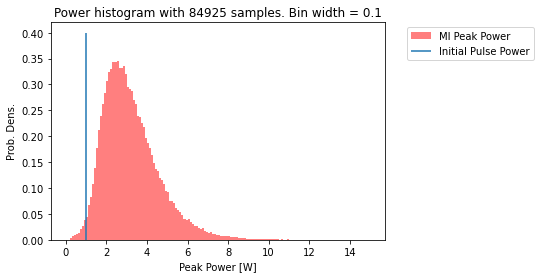

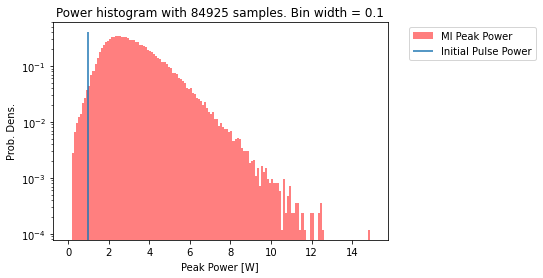

In [4]:
plt.figure()
plt.title('Plot of extracted peak values')
plt.plot(df,'r-',label="MI Peak powers")
plt.hlines( testAmplitude**2,0,len(df),label="Initial Pulse Power"  )
plt.ylabel('Peak Power [W]')
plt.xlabel('Peak number')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Pmax=df.max().max()
bins=np.linspace(0,np.ceil(Pmax),int(np.ceil(Pmax)*10+1))             
d_bins=bins[1]-bins[0]



print(f"Highest peak power recorded = {Pmax}W")
fig, ax = plt.subplots()
plt.title(f"Power histogram with {len(df)} samples. Bin width = {d_bins}")
ax.hist(df,bins,density=True,color='r',alpha=0.5,label='MI Peak Power')
ax.set_xlabel('Peak Power [W]')
ax.set_ylabel('Prob. Dens.')
ax.vlines( testAmplitude**2,0,0.4,label="Initial Pulse Power"  )
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

fig, ax = plt.subplots()
plt.title(f"Power histogram with {len(df)} samples. Bin width = {d_bins}")
ax.hist(df,bins,density=True,color='r',alpha=0.5,label='MI Peak Power')
ax.set_xlabel('Peak Power [W]')
ax.set_ylabel('Prob. Dens.')
ax.vlines( testAmplitude**2,0,0.4,label="Initial Pulse Power"  )
#ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Fit Gamma distribution to peak powers

$\Gamma_d(P,a,b)= \frac{P^{a-1}\exp(-P/b)}{\Gamma(a)b^a}$

C:\Users\okrarup\AppData\Local\Temp\ipykernel_21108\437777394.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return power_bin**(a-1)*np.exp(-power_bin/b)/gamma(a)/b**a


Gamma fit parameters:
 a-value = 5.908533137912351
 b-value ('Decay power') = 0.5238692836632528W
 
Gamma distribution properties:
 Most probable peak power = 2.571429738795482W
 Mean peak power = 3.0952990224587347W
 Spread of peak power = 1.2733939224054056W
 
Smallest non-zero prob = 1.1775095672652174e-05
 


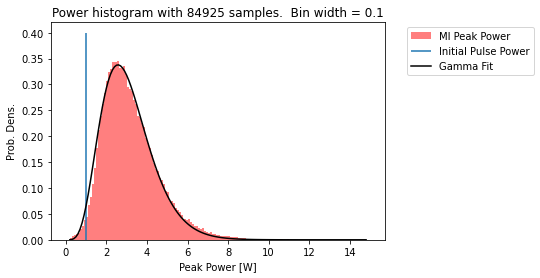

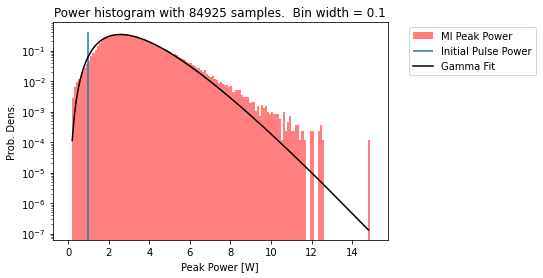

In [5]:
#Import libraries
from scipy.optimize import curve_fit
from scipy.special import gamma

#Get histogram data as numpy arrays
Pdens, bins_plot = np.histogram(df,bins,density=True)
bins_plot=bins_plot[0:-1]



#Remove bins with 0 occurences
threshold=0.0
idx_nonzero =np.where(Pdens>threshold)
Pdens = Pdens[idx_nonzero]
bins_plot = bins_plot[idx_nonzero]

#Define gamma distribution
def gamma_func(power_bin,a,b):
    #Gamma distribution: 
    # https://online.stat.psu.edu/stat414/lesson/15/15.4
    # https://en.wikipedia.org/wiki/Gamma_distribution
    return power_bin**(a-1)*np.exp(-power_bin/b)/gamma(a)/b**a


#Do fit and print parameters
params, param_cov = curve_fit(gamma_func, bins_plot, Pdens,p0=[3,4] )
print("Gamma fit parameters:")
print(f" a-value = {params[0]}")
print(f" b-value ('Decay power') = {params[1]}W")
print(' ')
print("Gamma distribution properties:")
print(f" Most probable peak power = {(params[0]-1)*params[1]}W")
print(f" Mean peak power = {(params[0])*params[1]}W")
print(f" Spread of peak power = {np.sqrt(params[0])*params[1]}W")
print(' ')
print(f"Smallest non-zero prob = {np.min(Pdens)*d_bins}")
print(' ')


#Plot fit
fig, ax = plt.subplots()
plt.title(f"Power histogram with {len(df)} samples.  Bin width = {d_bins}")
ax.hist(df,bins,density=True,color='r',alpha=0.5,label='MI Peak Power')
ax.vlines( testAmplitude**2,0,0.4,label="Initial Pulse Power"  )
ax.plot(bins_plot,gamma_func( bins_plot, params[0],params[1] ),'k-',label='Gamma Fit')
ax.set_xlabel('Peak Power [W]')
ax.set_ylabel('Prob. Dens.')
#ax.set_xscale('log')
#ax.set_yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

fig, ax = plt.subplots()
plt.title(f"Power histogram with {len(df)} samples.  Bin width = {d_bins}")
ax.hist(df,bins,density=True,color='r',alpha=0.5,label='MI Peak Power')
ax.vlines( testAmplitude**2,0,0.4,label="Initial Pulse Power"  )
ax.plot(bins_plot,gamma_func( bins_plot, params[0],params[1] ),'k-',label='Gamma Fit')
ax.set_xlabel('Peak Power [W]')
ax.set_ylabel('Prob. Dens.')
#ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
